In [540]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

from datetime import datetime

# **Preprocessing**

In [507]:
# Step 0 : filter on small caps and micro caps
#def filter_data(df, small_cap_value=1, micro_cap_value=1):
#    """Filters rows based on small_cap and micro_cap values and returns a copy of the filtered DataFrame."""
#    filtered_df = df[(df['small_cap'] == small_cap_value) & (df['micro_cap'] == micro_cap_value)].copy()
#    return filtered_df

In [541]:
# Step 1 : target creation + train_test_split
# Creating target variables to automate creation of quarterly, yearly and 2-yearly targets, because well, DON'T REPEAT YOURSELF!
def create_target_variable(df, frequency:int, threshold):
    if frequency == 1:
        col = 'mc_qtr_growth_pct'
    if frequency == 4:
        col = 'mc_yr_growth_pct'
    if frequency == 8:
        col = 'mc_2yr_growth_pct'
   #else:
   #    raise ValueError("Invalid frequency. Use 1 (quarterly), 4 (yearly), or 8 (2-year).")
    df[col] = df[col].shift(-frequency)
    df.dropna(subset=col, inplace=True)
    target_func = lambda x: 1 if (x[col] > threshold) else 0 #& (x.small_cap == 1)) else 0
    df['target'] = df.apply(target_func, axis=1)
    return df

In [509]:
#def drop_columns(df, cols_to_drop=None):
#    """Drops specified columns from the DataFrame."""
#
#    if cols_to_drop is None:
#       # Default columns to drop if none are specified
#        cols_to_drop = ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year']
#    return df.drop(cols_to_drop, axis=1, errors='ignore')


In [542]:
# Creating a custom function for the group split
def group_train_test_split(data, test_size=0.2, random_state=None):

    data['qtr'] = data.quarter.apply(lambda x : x.split('-')[1])


    # We split by groups (company ticker) while keeping the data structure intact.
    unique_groups = data['TICKER'].unique()
    train_groups, test_groups = train_test_split(unique_groups, test_size=test_size, random_state=random_state)

    # Split into train and test sets
    X_train = data[data['TICKER'].isin(train_groups)]
    X_test = data[data['TICKER'].isin(test_groups)]

    # Define columns to drop: Ticker, cik, date, quarter, year + growth columns
    cols_to_drop = ['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct', 'target']

    # Drop unwanted columns
    X_train = X_train.drop(cols_to_drop + ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', 'TICKER'], axis=1, errors='ignore')
    X_test = X_test.drop(cols_to_drop + ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', 'TICKER'], axis=1, errors='ignore')

    # Extract the target variable from the dataset
    y_train = data[data['TICKER'].isin(train_groups)]['target']
    y_test = data[data['TICKER'].isin(test_groups)]['target']

    return X_train, X_test, y_train, y_test


In [511]:
## FULL SET (not test set)
# # Creating a custom function to split data from target
def group_train_split(data):

    data['qtr'] = data.quarter.apply(lambda x : x.split('-')[1])

    # No test set is created, we are keeping all groups in the training set.
    train_groups = data['TICKER'].unique()

    # Select all data as training set
    X_train = data[data['TICKER'].isin(train_groups)]

    # Define columns to drop: Ticker, cik, date, quarter, year + growth columns
    cols_to_drop = ['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth',
                    'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct', 'target']

    # Drop unwanted columns
    X_train = X_train.drop(cols_to_drop + ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', 'TICKER'],
                           axis=1, errors='ignore')

    # Extract the target variable from the dataset
    y_train = data[data['TICKER'].isin(train_groups)]['target']

    return X_train, y_train

In [543]:
# Step 2: Identify numerical and categorical features
def identify_feature_types(df):
    """Identifies the numerical and categorical columns in the DataFrame."""
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Exclude 'Ticker' from categorical features as it's not needed for transformation
    if 'TICKER' in categorical_features:
        categorical_features.remove('TICKER')

    return numerical_features, categorical_features

In [544]:
# Step 3: Create preprocessing pipeline for numerical and categorical features
def create_preprocessing_pipeline(numerical_features, categorical_features):
    """Creates the preprocessing pipeline for numerical and categorical features."""
    # Preprocessing for numerical data: RobustScaler to make our numbers más robusto.
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaNs
        ('scaler', RobustScaler())
        #('scaler', MinMaxScaler()) # Scale the data
    ])

    # Preprocessing for categorical data: OneHotEncoder to give each category its own columm...
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categories
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categories
    ])

    # Combine the transformers into one big ColumnTransformer.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor


# Function to save the preprocessor
def save_preprocessor(preprocessor, file_path='~/models/'):
    """Saves the preproc with a timestamp."""
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    preproc_filename = f'preprocessor_{timestamp}.pkl'
    # Ensure model directory exists
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    file_path = os.path.join(file_path, preproc_filename   )
    with open(file_path, 'wb') as file:
        pickle.dump(preprocessor, file)

    print(f"Preprocessor saved to {file_path}")

In [545]:
# Step 4: Function to preprocess data in training mode (fitting the pipeline)
def preprocess_training_data(X_train):
    """Fits and transforms the training data using the provided pipeline."""
    # Identify feature types
    numerical_features, categorical_features = identify_feature_types(X_train)
    preprocessor = create_preprocessing_pipeline(numerical_features, categorical_features)

    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)

        # Save the preprocessor after fitting
    save_preprocessor(preprocessor)

    return X_train_processed, preprocessor

In [546]:
# Step 5: Function to preprocess new/unseen/test data in production mode (only transforming)
def preprocess_new_data(X_new, preprocessor):
    """Transforms new/unseen/test data using a pre-fitted pipeline."""
    if preprocessor is None:
        raise ValueError("The preprocessor must be fitted on training data first before transforming new data.")

    # Transform the new data (no fitting here)
    X_new_processed = preprocessor.transform(X_new)
    return X_new_processed

# **Training**

In [547]:
def save_model(model, model_type, model_dir='~/models/'):
    """Saves the trained model with a timestamp."""
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_filename = f'{model_type}_{timestamp}.pkl'

    # Ensure model directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the trained model
    model_path = os.path.join(model_dir, model_filename)
    with open(model_path, 'wb') as f_model:
        pickle.dump(model, f_model)

    print(f"Model saved to: {model_path}")
    return model_path

def evaluate_model(model, X_train, y_train, X_test, y_test, scoring_metrics=['accuracy', 'precision', 'recall', 'f1']):
    """Evaluates the model with cross-validation and test set metrics."""
    cv_metrics = {}
    for metric in scoring_metrics:
        with tqdm(total=5, desc=f"Cross-Validation ({metric})", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
            cv_metrics[metric] = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
            pbar.update(5)

    print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics[m].mean():.4f}' for m in cv_metrics])}")

    # Test on the test set
    y_pred_test = model.predict(X_test)

    # Calculate test set metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }

    # Combine cross-validated and test metrics
    metrics = {**{f'cv_{m}': cv_metrics[m].mean() for m in cv_metrics}, **test_metrics}
    return metrics

def train_logistic_regression_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates a logistic regression model, saves the trained model, and returns evaluation metrics."""

    model_type = 'logistic_regression'
    model = LogisticRegression(C=0.001, max_iter=2000, solver='lbfgs')

    # Train model with a progress bar
    with tqdm(total=100, desc=f"Training {model_type}", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        model.fit(X_train, y_train)
        pbar.update(100)

    # Check number of iterations
    print(f"Number of iterations: {model.n_iter_}")

    # Evaluate the model
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(model, model_type, model_dir)

    return metrics, model

def train_knn_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates a K-Nearest Neighbors model, saves the trained model, and returns evaluation metrics."""

    model_type = 'knn'
    knn = KNeighborsClassifier()

    # Train model with a progress bar
    with tqdm(total=100, desc=f"Training {model_type}", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        knn.fit(X_train, y_train)
        pbar.update(100)

    # Evaluate the model
    metrics = evaluate_model(knn, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(knn, model_type, model_dir)

    return metrics, knn

def train_svc_rbf_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates an SVM with RBF kernel, saves the trained model, and returns evaluation metrics."""

    model_type = 'svc_rbf'
    svc_rbf = SVC(kernel='rbf', probability=True)  # Set `probability=True` for log_loss and cross-validation

    # Train model with a progress bar
    #with tqdm(total=100, desc=f"Training {model_type}", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    svc_rbf.fit(X_train, y_train)
        #pbar.update(100)

    # Evaluate the model
    metrics = evaluate_model(svc_rbf, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(svc_rbf, model_type, model_dir)

    return metrics, svc_rbf


def train_xgb_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates an XGBClassifier model, saves the trained model, and returns evaluation metrics."""

    model_type = 'xgb_classifier'

    # Initialize XGBClassifier with specified parameters and verbose for progress monitoring
    xgb = XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=5, verbose=1)

    # Train the model
    xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

    # Evaluate the model
    metrics = evaluate_model(xgb, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(xgb, model_type, model_dir)

    return metrics, xgb

def fullset_train_xgb_and_save(X_train, y_train, model_dir='~/models/'):
    """Trains, evaluates an XGBClassifier model, saves the trained model, and returns evaluation metrics."""

    model_type = 'xgb_classifier'

    # Initialize XGBClassifier with specified parameters and verbose for progress monitoring
    xgb = XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=5, verbose=1)

    # Train the model
    #xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    xgb.fit(X_train, y_train, verbose=True)

    # Evaluate the model
    # metrics = evaluate_model(xgb, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(xgb, model_type, model_dir)

    return xgb  #metrics,

In [517]:
'''# Step 6: Function to train logistic regression, evaluate, and save the model
def train_logistic_regression_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates a logistic regression model, saves the trained model with a timestamp and returns evaluation metrics."""

    # Step 1: Train logistic regression model with a progress bar
    logistic_model = LogisticRegression(solver='saga', max_iter=2000)
    with tqdm(total=100, desc="Training Logistic Regression", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        logistic_model.fit(X_train, y_train)
        pbar.update(100)

    # Check number of iterations
    print(f"Number of iterations: {logistic_model.n_iter_}")

    # Step 2: Evaluate using cross-validation for accuracy, precision, recall, and F1-score
    cv_metrics = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        with tqdm(total=5, desc=f"Cross-Validation ({metric})", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
            cv_metrics[metric] = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring=metric)
            pbar.update(5)

    print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics[m].mean():.4f}' for m in cv_metrics])}")

    # Step 3: Test on the test set
    y_pred_test = logistic_model.predict(X_test)

    # Calculate test set metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }

    # Combine cross-validated and test metrics into a single dictionary
    metrics = {**{f'cv_{m}': cv_metrics[m].mean() for m in cv_metrics}, **test_metrics}

    # Step 4: Save the model with timestamp and type
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_filename = f'logistic_regression_{timestamp}.pkl'

    # Ensure model directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the trained model
    model_path = os.path.join(model_dir, model_filename)
    with open(model_path, 'wb') as f_model:
        pickle.dump(logistic_model, f_model)

    print(f"Model saved to: {model_path}")

    return metrics, logistic_model'''

'# Step 6: Function to train logistic regression, evaluate, and save the model\ndef train_logistic_regression_and_save(X_train, y_train, X_test, y_test, model_dir=\'~/models/\'):\n    """Trains, evaluates a logistic regression model, saves the trained model with a timestamp and returns evaluation metrics."""\n\n    # Step 1: Train logistic regression model with a progress bar\n    logistic_model = LogisticRegression(solver=\'saga\', max_iter=2000)\n    with tqdm(total=100, desc="Training Logistic Regression", bar_format=\'{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]\') as pbar:\n        logistic_model.fit(X_train, y_train)\n        pbar.update(100)\n\n    # Check number of iterations\n    print(f"Number of iterations: {logistic_model.n_iter_}")\n\n    # Step 2: Evaluate using cross-validation for accuracy, precision, recall, and F1-score\n    cv_metrics = {}\n    for metric in [\'accuracy\', \'precision\', \'recall\', \'f1\']:\n        with tqdm(total=5, desc=f"Cross-Validation 

# Grid search

In [518]:
def run_grid_search(X_train, y_train):
    """Runs a grid search on logistic regression model to find the best hyperparameters."""

    # Define the parameter grid for Logistic Regression
    param_grid = {
        'solver': ['saga', 'lbfgs'],  # Different solvers
        'max_iter': [1500, 2000, 2500],  # Number of iterations
        'C': [0.005, 0.007, 0.01, 0.12, 0.15]  # Regularization strength
    }

    # Create a Logistic Regression model
    logistic_model = LogisticRegression()

    # Set up the GridSearchCV
    grid_search = GridSearchCV(
        estimator=logistic_model,
        param_grid=param_grid,
        scoring='precision',  # Choose appropriate scoring metric
        cv=5,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=1  # Verbosity level
    )

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

In [519]:
def knn_run_grid_search(X_train, y_train):
    """Runs a grid search on knn model to find the best hyperparameters."""

    # Define the parameter grid for Logistic Regression
    param_grid = {
        'n_neighbors': [550],  # Different solvers
        #'max_iter': [1500, 2000, 2500],  # Number of iterations
        #'C': [0.005, 0.007, 0.01, 0.12, 0.15]  # Regularization strength
    }

    # Create a Logistic Regression model
    knn_model = KNeighborsClassifier()

    # Set up the GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn_model,
        param_grid=param_grid,
        scoring='precision',  # Choose appropriate scoring metric
        cv=3,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=1  # Verbosity level
    )

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

In [548]:
def run_xgboost(X_train, y_train):
    """Runs a grid search on knn model to find the best hyperparameters."""

    # Define the parameter grid for Logistic Regression
    param_grid = param_grid = {'n_estimators': [200],
                               'learning_rate': [0.01],
                               'max_depth': [5]}

#{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

    # Create a Logistic Regression model
    model = XGBClassifier()

    # Set up the search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='precision',  # Choose appropriate scoring metric
        cv=3,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=1  # Verbosity level
    )

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

# **Running the functions on the dataset**

In [549]:

# preprocessor import create_target_variable, group_train_test_split, identify_feature_types, create_preprocessing_pipeline,preprocess_training_data, preprocess_new_data,train_logistic_regression, filter_data


df = pd.read_csv('~/Small-Cap-Scout/raw_data/data_for_preprocessing.csv', index_col=[0])


In [550]:
df.head()

,cik,date,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,...,TICKER,market_cap,mc_qtr_growth,mc_qtr_growth_pct,mc_yr_growth,mc_yr_growth_pct,mc_2yr_growth,mc_2yr_growth_pct,small_cap,micro_cap
0,1750,2011-02-28,1.655991e+09,9.278390e+08,54716000.0,409295000.0,8.513950e+08,419182000.0,432213000.0,804596000.0,...,AIR,1045.889727,46.783392,0.046825,77.281557,0.079786,NaN,NaN,1,0
1,1750,2011-05-31,1.703727e+09,9.139850e+08,57433000.0,465365000.0,8.684380e+08,416010000.0,452428000.0,835289000.0,...,AIR,1024.472219,-21.417508,-0.020478,306.796787,0.427487,NaN,NaN,1,0
2,1750,2011-08-31,1.752372e+09,9.442470e+08,35523000.0,472856000.0,9.032430e+08,350085000.0,553158000.0,849129000.0,...,AIR,882.619592,-141.852627,-0.138464,255.395538,0.407184,NaN,NaN,1,0
3,1750,2011-11-30,1.821612e+09,9.550530e+08,27870000.0,521431000.0,9.582200e+08,374944000.0,583276000.0,863392000.0,...,AIR,727.886752,-154.732840,-0.175311,-271.219583,-0.271462,NaN,NaN,1,0
4,1750,2012-02-29,2.220293e+09,1.065389e+09,59294000.0,797765000.0,1.328974e+09,560986000.0,767988000.0,891319000.0,...,AIR,899.522315,171.635564,0.235800,-146.367411,-0.139945,-69.085854,-0.071325,1,0


In [551]:
df.columns

Index(['cik', 'date', 'Assets', 'AssetsCurrent', 'Cash', 'AssetsNoncurrent',
       'Liabilities', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent', 'Equity',
       'HolderEquity', 'RetainedEarnings', 'AdditionalPaidInCapital',
       'TreasuryStockValue', 'TemporaryEquity', 'RedeemableEquity',
       'LiabilitiesAndEquity', 'Revenues', 'CostOfRevenue', 'GrossProfit',
       'OperatingExpenses', 'OperatingIncomeLoss',
       'IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit',
       'AllIncomeTaxExpenseBenefit', 'IncomeLossFromContinuingOperations',
       'IncomeLossFromDiscontinuedOperationsNetOfTax', 'ProfitLoss',
       'NetIncomeLossAttributableToNoncontrollingInterest', 'NetIncomeLoss',
       'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInOperatingActivities',
       'NetCa

In [524]:
# Step 2: Drop unwanted columns before target creation
#df_cleaned = drop_columns(df, cols_to_drop=['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', ])

In [525]:
#df_cleaned.columns

In [552]:
# Step 3: Create target variables and split the data
df_qtr = create_target_variable(df, frequency=1, threshold=0.5)
df_yr = create_target_variable(df, frequency=4, threshold=0.5)
df_2yr = create_target_variable(df, frequency=8, threshold=0.5)

In [553]:
X_train_qtr, X_test_qtr, y_train_qtr, y_test_qtr = group_train_test_split(df_qtr)
X_train_yr, X_test_yr, y_train_yr, y_test_yr = group_train_test_split(df_yr)
X_train_2yr, X_test_2yr, y_train_2yr, y_test_2yr = group_train_test_split(df_2yr)

In [528]:
#X_train_qtr, y_train_qtr = group_train_split(df_qtr)
#X_train_yr, y_train_yr = group_train_split(df_yr)
#X_train_2yr, y_train_2yr = group_train_split(df_2yr)

In [554]:
X_train_qtr.columns

Index(['Assets', 'AssetsCurrent', 'Cash', 'AssetsNoncurrent', 'Liabilities',
       'LiabilitiesCurrent', 'LiabilitiesNoncurrent', 'Equity', 'HolderEquity',
       'RetainedEarnings', 'AdditionalPaidInCapital', 'TreasuryStockValue',
       'TemporaryEquity', 'RedeemableEquity', 'LiabilitiesAndEquity',
       'Revenues', 'CostOfRevenue', 'GrossProfit', 'OperatingExpenses',
       'OperatingIncomeLoss',
       'IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit',
       'AllIncomeTaxExpenseBenefit', 'IncomeLossFromContinuingOperations',
       'IncomeLossFromDiscontinuedOperationsNetOfTax', 'ProfitLoss',
       'NetIncomeLossAttributableToNoncontrollingInterest', 'NetIncomeLoss',
       'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInOperatingActivities',
       'NetCashProvidedByUse

In [530]:
# Step 4:  Identify feature types after splitting
#numerical_features_qtr, categorical_features_qtr = identify_feature_types(X_train_qtr)
#numerical_features_yr, categorical_features_yr = identify_feature_types(X_train_yr)
#numerical_features_2yr, categorical_features_2yr = identify_feature_types(X_train_2yr)

In [531]:
# Step 5: Create the preprocessing pipeline
#preprocessor_qtr = create_preprocessing_pipeline(numerical_features_qtr, categorical_features_qtr)
#preprocessor_yr = create_preprocessing_pipeline(numerical_features_yr, categorical_features_yr)
#preprocessor_2yr = create_preprocessing_pipeline(numerical_features_2yr, categorical_features_2yr)


In [555]:
# Step 6: Preprocess the training data
X_train_qtr_processed, preprocessor_qtr = preprocess_training_data(X_train_qtr)
X_train_yr_processed, preprocessor_yr = preprocess_training_data(X_train_yr)
X_train_2yr_processed, preprocessor_2yr = preprocess_training_data(X_train_2yr)


Preprocessor saved to ~/models/preprocessor_2024-09-12_12-27-39.pkl
Preprocessor saved to ~/models/preprocessor_2024-09-12_12-27-39.pkl
Preprocessor saved to ~/models/preprocessor_2024-09-12_12-27-40.pkl


In [556]:
pd.DataFrame(X_train_qtr_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
count,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,...,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000
mean,3.151248,5.271482,2.437065,3.293660,3.957481,6.952204,3.250348,1.985638,1.992290,2.657312,...,0.000606,0.018403,0.000199,0.000581,0.000374,0.068289,0.250046,0.250652,0.250943,0.248360
std,27.002397,58.141102,21.335220,16.170033,37.781648,79.577312,17.110606,10.692536,10.753424,18.797690,...,0.024615,0.134405,0.014116,0.024104,0.019328,0.252243,0.433041,0.433390,0.433557,0.432063
min,-12.851469,-27.854068,-0.358190,-0.573231,-17.912823,-40.099988,-0.297526,-15.396027,-15.499192,-198.506987,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.185149,-0.184294,-0.202394,-0.059642,-0.155920,-0.134399,-0.052801,-0.180664,-0.180740,-0.201878,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.814851,0.815706,0.797606,0.940358,0.844080,0.865601,0.947199,0.819336,0.819260,0.798122,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1045.144571,2285.318365,1300.448494,534.253903,1499.157628,3375.357122,722.151760,300.384659,302.431417,778.535382,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [557]:
pd.DataFrame(X_train_qtr).describe()

,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,HolderEquity,RetainedEarnings,...,CashProvidedByUsedInFinancingActivitiesDiscontinuedOperations,EffectOfExchangeRateFinal,CashPeriodIncreaseDecreaseIncludingExRateEffectFinal,GDP,interest_rate,unemployment_rate,median_cpi,market_cap,small_cap,micro_cap
count,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,1.204140e+05,...,1.204140e+05,1.204140e+05,1.204140e+05,120414.000000,120414.000000,120414.000000,120414.000000,1.204140e+05,120414.000000,120414.000000
mean,1.270783e+10,9.485398e+09,6.194045e+08,3.150193e+09,1.009379e+10,7.718379e+09,2.340623e+09,2.566592e+09,2.556681e+09,1.565712e+09,...,1.023705e+05,-2.983554e+06,4.054279e+07,2.477431,0.975467,5.472720,2.775783,7.331802e+03,0.681889,0.406888
std,1.021531e+11,1.006025e+11,4.937410e+09,1.518945e+10,9.245016e+10,8.649141e+10,1.212217e+10,1.251960e+10,1.250575e+10,1.095964e+10,...,4.510650e+07,1.509264e+08,2.683492e+09,8.912384,1.352208,1.839165,1.329529,4.140965e+04,0.465745,0.491256
min,-4.783227e+10,-4.783227e+10,-2.747500e+07,-4.822030e+08,-4.342195e+10,-4.342195e+10,-1.729015e+08,-1.778513e+10,-1.778513e+10,-1.157194e+11,...,-3.140119e+09,-3.234200e+10,-1.736000e+11,-69.630993,0.050000,3.400000,-0.286064,5.317758e-06,0.000000,0.000000
25%,8.585634e+07,4.518150e+07,8.579391e+06,2.403958e+05,2.847050e+07,1.605475e+07,4.762188e+05,3.012683e+07,2.954330e+07,-1.012859e+08,...,0.000000e+00,0.000000e+00,-1.325850e+07,1.388811,0.090000,3.900000,1.961900,7.944983e+01,0.000000,0.000000
50%,7.862965e+08,3.640685e+08,5.541750e+07,5.626605e+07,4.099995e+08,1.621310e+08,3.788350e+07,2.416615e+08,2.397360e+08,1.641550e+07,...,0.000000e+00,0.000000e+00,-3.668000e+03,2.590671,0.240000,5.000000,2.452308,5.942361e+02,1.000000,0.000000
75%,3.868970e+09,1.775498e+09,2.400000e+08,9.395985e+08,2.475430e+09,1.102940e+09,7.089355e+08,1.201000e+09,1.192499e+09,4.817455e+08,...,0.000000e+00,0.000000e+00,1.476250e+07,4.056326,1.510000,6.700000,2.966116,3.157140e+03,1.000000,1.000000
max,3.954687e+12,3.954687e+12,3.010060e+11,5.019120e+11,3.668788e+12,3.668788e+12,5.116530e+11,3.519540e+11,3.519540e+11,4.539270e+11,...,1.199100e+10,9.155000e+09,2.639780e+11,45.706033,5.330000,14.700000,8.048036,2.974308e+06,1.000000,1.000000


In [558]:
# Step 7 : then the test data
X_test_qtr_processed = preprocess_new_data(X_test_qtr, preprocessor_qtr)
X_test_yr_processed = preprocess_new_data(X_test_yr, preprocessor_yr)
X_test_2yr_processed = preprocess_new_data(X_test_2yr, preprocessor_2yr)

In [487]:
# STEP 8 : Full set train!!
model_qtr_xgb = fullset_train_xgb_and_save(X_train_qtr_processed, y_train_qtr)

/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:11:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved to: ~/models/xgb_classifier_2024-09-12_11-11-49.pkl


In [488]:
model_yr_xgb = fullset_train_xgb_and_save(X_train_yr_processed, y_train_yr)

/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved to: ~/models/xgb_classifier_2024-09-12_11-12-04.pkl


In [489]:
model_2yr_xgb = fullset_train_xgb_and_save(X_train_2yr_processed, y_train_2yr)

/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved to: ~/models/xgb_classifier_2024-09-12_11-12-06.pkl


In [58]:
# Step 8 :Train for quarterly (frequency=1), yearly (frequency=4), and 2-year (frequency=8) predictions
y_pred_qtr_log_reg, model_qtr_log_reg = train_logistic_regression_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

Training logistic_regression: 100%|██████████ [elapsed: 00:04 left: 00:00]


Number of iterations: [352]


Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:19 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:19 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:19 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:19 left: 00:00]

Cross-validated Metrics: accuracy: 0.6632, precision: 0.3379, recall: 0.5131, f1: 0.4002
Model saved to: ~/models/logistic_regression_2024-09-11_16-02-30.pkl


In [124]:
y_pred_yr_log_reg, model_yr_log_reg = train_logistic_regression_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

Training logistic_regression: 100%|██████████ [elapsed: 00:01 left: 00:00]


Number of iterations: [140]


Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:07 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:06 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:06 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:06 left: 00:00]

Cross-validated Metrics: accuracy: 0.6606, precision: 0.3430, recall: 0.5238, f1: 0.4065
Model saved to: ~/models/logistic_regression_2024-09-11_11-59-14.pkl


In [125]:
y_pred_2yr_log_reg, model_2yr = train_logistic_regression_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)


Training logistic_regression: 100%|██████████ [elapsed: 00:06 left: 00:00]


Number of iterations: [532]


Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:13 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:13 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:13 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:13 left: 00:00]

Cross-validated Metrics: accuracy: 0.6596, precision: 0.3333, recall: 0.5061, f1: 0.3966
Model saved to: ~/models/logistic_regression_2024-09-11_12-01-22.pkl


In [272]:
y_pred_qtr_xgb, model_qtr_xgb = train_xgb_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

[0]	validation_0-logloss:0.60780
[1]	validation_0-logloss:0.60730
[2]	validation_0-logloss:0.60681
[3]	validation_0-logloss:0.60632
[4]	validation_0-logloss:0.60584
[5]	validation_0-logloss:0.60538
[6]	validation_0-logloss:0.60492
[7]	validation_0-logloss:0.60446
[8]	validation_0-logloss:0.60402
[9]	validation_0-logloss:0.60359
[10]	validation_0-logloss:0.60316
[11]	validation_0-logloss:0.60275
[12]	validation_0-logloss:0.60234
[13]	validation_0-logloss:0.60194
[14]	validation_0-logloss:0.60155
[15]	validation_0-logloss:0.60118
[16]	validation_0-logloss:0.60080


/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.60043
[18]	validation_0-logloss:0.60006
[19]	validation_0-logloss:0.59972
[20]	validation_0-logloss:0.59937
[21]	validation_0-logloss:0.59901
[22]	validation_0-logloss:0.59869
[23]	validation_0-logloss:0.59835
[24]	validation_0-logloss:0.59802
[25]	validation_0-logloss:0.59768
[26]	validation_0-logloss:0.59738
[27]	validation_0-logloss:0.59707
[28]	validation_0-logloss:0.59677
[29]	validation_0-logloss:0.59645
[30]	validation_0-logloss:0.59616
[31]	validation_0-logloss:0.59586
[32]	validation_0-logloss:0.59558
[33]	validation_0-logloss:0.59529
[34]	validation_0-logloss:0.59500
[35]	validation_0-logloss:0.59471
[36]	validation_0-logloss:0.59446
[37]	validation_0-logloss:0.59418
[38]	validation_0-logloss:0.59392
[39]	validation_0-logloss:0.59367
[40]	validation_0-logloss:0.59340
[41]	validation_0-logloss:0.59316
[42]	validation_0-logloss:0.59291
[43]	validation_0-logloss:0.59265
[44]	validation_0-logloss:0.59242
[45]	validation_0-logloss:0.59217
[46]	validatio

Cross-Validation (accuracy):   0%|           [elapsed: 00:00 left: ?]/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboo

Cross-validated Metrics: accuracy: 0.7081, precision: 0.6512, recall: 0.0305, f1: 0.0579
Model saved to: ~/models/xgb_classifier_2024-09-11_23-42-28.pkl


In [273]:
y_pred_yr_xgb, model_yr_xgb = train_xgb_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

[0]	validation_0-logloss:0.61073
[1]	validation_0-logloss:0.61021
[2]	validation_0-logloss:0.60971
[3]	validation_0-logloss:0.60922
[4]	validation_0-logloss:0.60873
[5]	validation_0-logloss:0.60827
[6]	validation_0-logloss:0.60780
[7]	validation_0-logloss:0.60734
[8]	validation_0-logloss:0.60690
[9]	validation_0-logloss:0.60645
[10]	validation_0-logloss:0.60601
[11]	validation_0-logloss:0.60559
[12]	validation_0-logloss:0.60517
[13]	validation_0-logloss:0.60476
[14]	validation_0-logloss:0.60436
[15]	validation_0-logloss:0.60397
[16]	validation_0-logloss:0.60358


/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.60320
[18]	validation_0-logloss:0.60283
[19]	validation_0-logloss:0.60247
[20]	validation_0-logloss:0.60211
[21]	validation_0-logloss:0.60176
[22]	validation_0-logloss:0.60142
[23]	validation_0-logloss:0.60108
[24]	validation_0-logloss:0.60076
[25]	validation_0-logloss:0.60043
[26]	validation_0-logloss:0.60012
[27]	validation_0-logloss:0.59982
[28]	validation_0-logloss:0.59952
[29]	validation_0-logloss:0.59922
[30]	validation_0-logloss:0.59893
[31]	validation_0-logloss:0.59864
[32]	validation_0-logloss:0.59837
[33]	validation_0-logloss:0.59806
[34]	validation_0-logloss:0.59780
[35]	validation_0-logloss:0.59750
[36]	validation_0-logloss:0.59721
[37]	validation_0-logloss:0.59692
[38]	validation_0-logloss:0.59666
[39]	validation_0-logloss:0.59638
[40]	validation_0-logloss:0.59612
[41]	validation_0-logloss:0.59587
[42]	validation_0-logloss:0.59562
[43]	validation_0-logloss:0.59535
[44]	validation_0-logloss:0.59511
[45]	validation_0-logloss:0.59485
[46]	validatio

Cross-Validation (accuracy):   0%|           [elapsed: 00:00 left: ?]/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboo

Cross-validated Metrics: accuracy: 0.7091, precision: 0.6842, recall: 0.0282, f1: 0.0538
Model saved to: ~/models/xgb_classifier_2024-09-11_23-43-26.pkl


In [274]:
y_pred_2yr_xgb, model_2yr_xgb = train_xgb_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)

[0]	validation_0-logloss:0.60455
[1]	validation_0-logloss:0.60405
[2]	validation_0-logloss:0.60357
[3]	validation_0-logloss:0.60310
[4]	validation_0-logloss:0.60263
[5]	validation_0-logloss:0.60217
[6]	validation_0-logloss:0.60172
[7]	validation_0-logloss:0.60129
[8]	validation_0-logloss:0.60086
[9]	validation_0-logloss:0.60044
[10]	validation_0-logloss:0.60002
[11]	validation_0-logloss:0.59961
[12]	validation_0-logloss:0.59920
[13]	validation_0-logloss:0.59881
[14]	validation_0-logloss:0.59841
[15]	validation_0-logloss:0.59802


/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-logloss:0.59765
[17]	validation_0-logloss:0.59727
[18]	validation_0-logloss:0.59690
[19]	validation_0-logloss:0.59655
[20]	validation_0-logloss:0.59620
[21]	validation_0-logloss:0.59585
[22]	validation_0-logloss:0.59551
[23]	validation_0-logloss:0.59517
[24]	validation_0-logloss:0.59485
[25]	validation_0-logloss:0.59452
[26]	validation_0-logloss:0.59419
[27]	validation_0-logloss:0.59388
[28]	validation_0-logloss:0.59356
[29]	validation_0-logloss:0.59325
[30]	validation_0-logloss:0.59295
[31]	validation_0-logloss:0.59265
[32]	validation_0-logloss:0.59235
[33]	validation_0-logloss:0.59207
[34]	validation_0-logloss:0.59179
[35]	validation_0-logloss:0.59152
[36]	validation_0-logloss:0.59124
[37]	validation_0-logloss:0.59097
[38]	validation_0-logloss:0.59071
[39]	validation_0-logloss:0.59047
[40]	validation_0-logloss:0.59021
[41]	validation_0-logloss:0.58996
[42]	validation_0-logloss:0.58969
[43]	validation_0-logloss:0.58946
[44]	validation_0-logloss:0.58922
[45]	validatio

Cross-Validation (accuracy):   0%|           [elapsed: 00:00 left: ?]/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/xgboo

Cross-validated Metrics: accuracy: 0.7083, precision: 0.6962, recall: 0.0363, f1: 0.0682
Model saved to: ~/models/xgb_classifier_2024-09-11_23-44-19.pkl


In [ ]:
"""Evaluates the model with cross-validation and test set metrics."""
'''with tqdm(total=5, desc=f"Cross-Validation", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    cv_metrics = cross_validate(SVC(kernel = 'rbf', class_weight='balanced'), X_train_qtr_processed[:10000], y_train_qtr[:10000], cv=3, scoring=['accuracy', 'precision', 'recall', 'f1'])
    pbar.update(5)

    #print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics.mean():.4f}' for m in cv_metrics])}")'''

Cross-Validation: 100%|██████████ [elapsed: 00:04 left: 00:00]


In [31]:
y_pred_qtr_knn, model_qtr_knn = train_knn_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

Training knn: 100%|██████████ [elapsed: 00:00 left: 00:00]
Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:12 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:12 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:12 left: 00:00]


Cross-validated Metrics: accuracy: 0.7477, precision: 0.4056, recall: 0.2794, f1: 0.3283
Model saved to: ~/models/knn_2024-09-11_15-50-38.pkl


In [129]:
y_pred_yr_knn, model_yr_knn = train_knn_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

Training knn: 100%|██████████ [elapsed: 00:00 left: 00:00]
Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:12 left: 00:00]


Cross-validated Metrics: accuracy: 0.7298, precision: 0.3303, recall: 0.2014, f1: 0.2469
Model saved to: ~/models/knn_2024-09-11_12-31-40.pkl


In [130]:
y_pred_2yr_knn, model_2yr_knn = train_knn_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)

Training knn: 100%|██████████ [elapsed: 00:00 left: 00:00]
Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:11 left: 00:00]


Cross-validated Metrics: accuracy: 0.7289, precision: 0.3252, recall: 0.1941, f1: 0.2402
Model saved to: ~/models/knn_2024-09-11_12-35-40.pkl


In [28]:
"""Evaluates the model with cross-validation and test set metrics."""
with tqdm(total=5, desc=f"Cross-Validation", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    cv_metrics = cross_validate(SVC(kernel = 'rbf', class_weight='balanced'), X_train_qtr_processed[:10000], y_train_qtr[:10000], cv=3, scoring=['accuracy', 'precision', 'recall', 'f1'])
    pbar.update(5)

    #print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics.mean():.4f}' for m in cv_metrics])}")

Cross-Validation: 100%|██████████ [elapsed: 00:04 left: 00:00]


In [30]:
cv_metrics

{'fit_time': array([0.71196508, 0.65307307, 0.65739298]),
 'score_time': array([1.00231981, 0.83814096, 0.80731201]),
 'test_accuracy': array([0.69406119, 0.64506451, 0.67566757]),
 'test_precision': array([0.27086495, 0.25572519, 0.26061915]),
 'test_recall': array([0.85817308, 0.9686747 , 0.87019231]),
 'test_f1': array([0.41176471, 0.4046301 , 0.40110803])}

In [29]:
pd.DataFrame(X_train_qtr_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
count,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,...,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000
mean,0.014093,0.013393,0.001951,0.011064,0.012734,0.012177,0.014410,0.055566,0.055539,0.230144,...,0.000607,0.016781,0.000116,0.000582,0.000374,0.068423,0.250050,0.250823,0.250973,0.248154
std,0.029071,0.028856,0.013157,0.042425,0.027675,0.026344,0.024527,0.033659,0.033611,0.018101,...,0.024631,0.128452,0.010789,0.024120,0.019341,0.252471,0.433043,0.433489,0.433575,0.431943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010949,0.010939,0.000121,0.001541,0.010108,0.010104,0.009839,0.048932,0.048931,0.227502,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011115,0.011015,0.000281,0.001724,0.010202,0.010141,0.009910,0.049525,0.049520,0.227695,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.011814,0.011338,0.000879,0.004523,0.010685,0.010364,0.011182,0.052031,0.052007,0.228461,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
"""Evaluates the model with cross-validation and test set metrics."""
with tqdm(total=5, desc=f"Cross-Validation", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    cv_metrics = cross_validate(SVC(kernel = 'rbf'), X_train_qtr_processed, y_train_qtr, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    pbar.update(5)

    #print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics.mean():.4f}' for m in cv_metrics])}")

Cross-Validation:   0%|           [elapsed: 00:00 left: ?]/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predict

In [160]:
y_pred_qtr_svc, model_qtr_svc = train_svc_rbf_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

Training svc_rbf:   0%|           [elapsed: 00:00 left: ?]

In [ ]:
y_pred_yr_svc, model_yr_svc = train_svc_rbf_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

In [ ]:
y_pred_2yr_svc, model_2yr_svc = train_svc_rbf_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)

In [27]:
# Step 10: Print metrics for each model
print("1 Quarter Ahead Metrics:", y_pred_qtr)
print("1 Year Ahead Metrics:", y_pred_yr)
print("2 Years Ahead Metrics:", y_pred_2yr)

1 Quarter Ahead Metrics: {'cv_accuracy': np.float64(0.5861177525890302), 'cv_precision': np.float64(0.28886531098782686), 'cv_recall': np.float64(0.3746608634582686), 'cv_f1': np.float64(0.32563369780978374), 'accuracy': 0.5739110464671209, 'precision': np.float64(0.28430531732418524), 'recall': np.float64(0.3731007315700619), 'f1': np.float64(0.32270625456315405)}
1 Year Ahead Metrics: {'cv_accuracy': np.float64(0.5847497987573081), 'cv_precision': np.float64(0.2876763455297774), 'cv_recall': np.float64(0.37019406810692057), 'cv_f1': np.float64(0.3235231859899204), 'accuracy': 0.6013502387617322, 'precision': np.float64(0.3058765674944677), 'recall': np.float64(0.3812442537542139), 'f1': np.float64(0.33942701227830835)}
2 Years Ahead Metrics: {'cv_accuracy': np.float64(0.5855911208007135), 'cv_precision': np.float64(0.2907180862789915), 'cv_recall': np.float64(0.378417465607723), 'cv_f1': np.float64(0.32827805522691694), 'accuracy': 0.6088211708099439, 'precision': np.float64(0.304605

In [67]:
# Let's try a grid search - QUARTER
best_model_qtr, best_params_qtr, best_score_qtr = run_grid_search(X_train_qtr_processed, y_train_qtr)

print(f"Best Model - QUARTER: {best_model_qtr.__class__.__name__}")
print(f"Best Parameters - QUARTER: {best_params_qtr}")
print(f"Best Score - QUARTER: {best_score_qtr:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [136]:
# Let's try a grid search - YEAR
best_model_yr, best_params_yr, best_score_yr = run_grid_search(X_train_yr_processed, y_train_yr)

print(f"Best Model - YEAR: {best_model_yr.__class__.__name__}")
print(f"Best Parameters - YEAR: {best_params_yr}")
print(f"Best Score - YEAR: {best_score_yr:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 0.15, 'max_iter': 1500, 'solver': 'lbfgs'}
Best cross-validation score: 0.3543
Best Model - YEAR: LogisticRegression
Best Parameters - YEAR: {'C': 0.15, 'max_iter': 1500, 'solver': 'lbfgs'}
Best Score - YEAR: 0.3543


In [ ]:
# Let's try a grid search - 2 YEAR
best_model_2yr, best_params_2yr, best_score_2yr = run_grid_search(X_train_2yr_processed, y_train_2yr)

print(f"Best Model - YEAR: {best_model_2yr.__class__.__name__}")
print(f"Best Parameters - YEAR: {best_params_2yr}")
print(f"Best Score - YEAR: {best_score_2yr:.4f}")

In [105]:
# knn grid search
# Let's try a grid search - QUARTER
best_model_qtr, best_params_qtr, best_score_qtr = knn_run_grid_search(X_train_qtr_processed, y_train_qtr)

print(f"Best Model - QUARTER: {best_model_qtr.__class__.__name__}")
print(f"Best Parameters - QUARTER: {best_params_qtr}")
print(f"Best Score - QUARTER: {best_score_qtr:.4f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'n_neighbors': 550}
Best cross-validation score: 0.5641
Best Model - QUARTER: KNeighborsClassifier
Best Parameters - QUARTER: {'n_neighbors': 550}
Best Score - QUARTER: 0.5641


In [559]:
# XGBOOS  search
# year
best_model_2yr, best_params_2yr, best_score_2yr = run_xgboost(X_train_2yr_processed, y_train_2yr)

print(f"Best Model - 2yr: {best_model_2yr.__class__.__name__}")
print(f"Best Parameters - 2yr: {best_params_2yr}")
print(f"Best Score - 2yr: {best_score_2yr:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.6742
Best Model - 2yr: XGBClassifier
Best Parameters - 2yr: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best Score - 2yr: 0.6742


In [560]:
best_model = XGBClassifier(learning_rate= 0.01, max_depth= 5, n_estimators= 200)
best_model.fit(X_train_2yr_processed, y_train_2yr)
predictions = best_model.predict(X_test_2yr_processed)

report = classification_report(y_test_2yr, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.71      0.99      0.83     20817
           1       0.66      0.03      0.06      8893

    accuracy                           0.71     29710
   macro avg       0.68      0.51      0.44     29710
weighted avg       0.69      0.71      0.60     29710



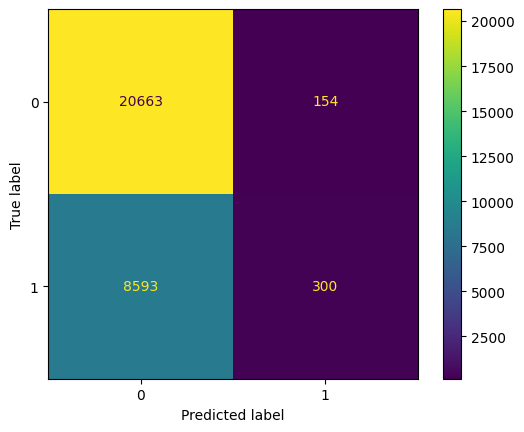

In [561]:
cm = confusion_matrix(y_test_2yr, predictions, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)

disp.plot()
plt.show()

In [569]:
import plotly.express as px
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_2yr, predictions)

# Create a heatmap with Plotly
fig = px.imshow(conf_matrix,
                text_auto=True,
                color_continuous_scale='Jet',
                labels=dict(x="Predicted", y="Actual", color="Viridis"),
                title="Confusion Matrix - 2 Year Market Cap")

# Show the plot
fig.show()

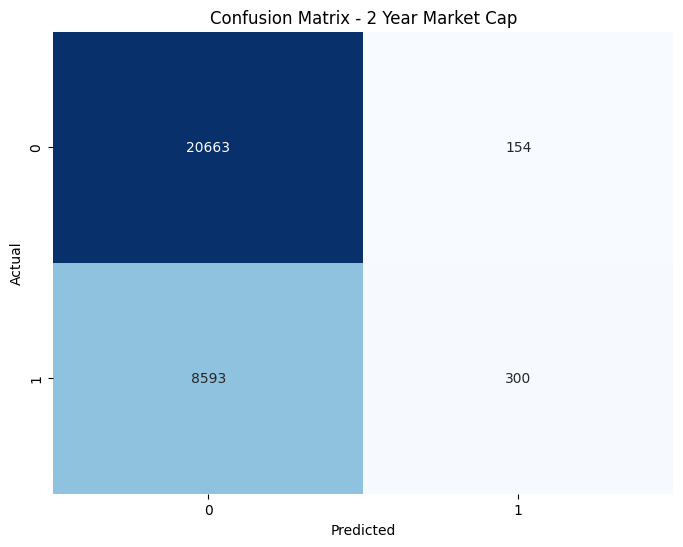

In [563]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_2yr, predictions)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - 2 Year Market Cap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



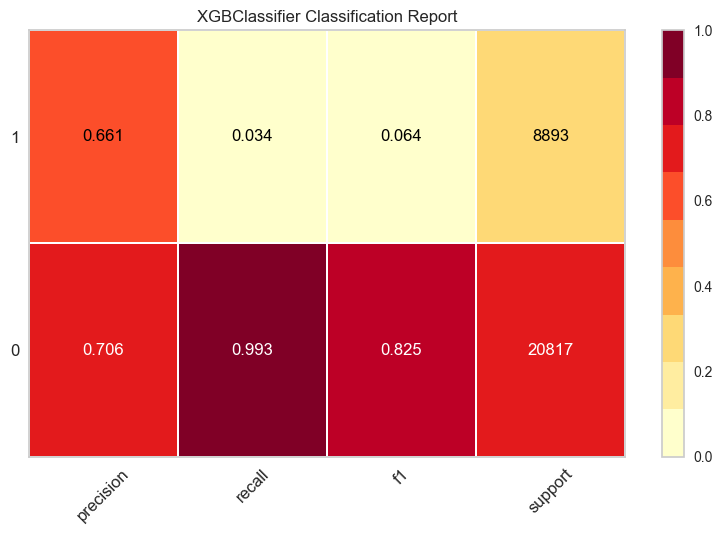

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [564]:
from yellowbrick.classifier import ClassificationReport
from xgboost import XGBClassifier

# Train the model
best_model = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=200)
best_model.fit(X_train_2yr_processed, y_train_2yr)

# Create the classification report
visualizer = ClassificationReport(best_model, support=True)

# Fit the visualizer with the test data
visualizer.score(X_test_2yr_processed, y_test_2yr)
visualizer.show()

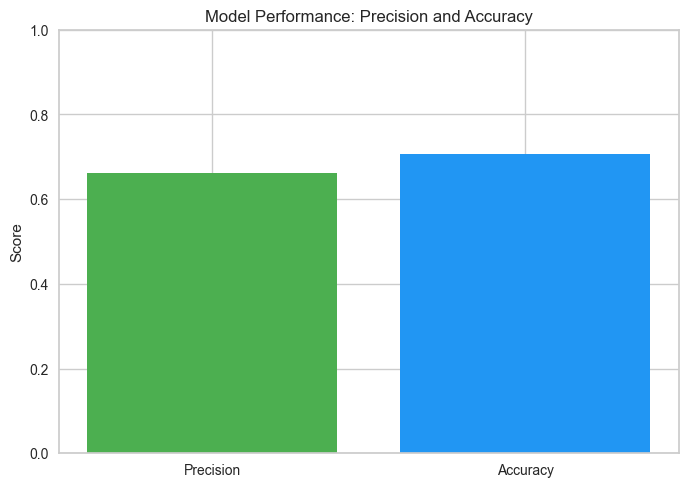

In [570]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score
from yellowbrick.style import set_palette

# Train the XGBoost model
best_model = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=200)
best_model.fit(X_train_2yr_processed, y_train_2yr)

# Predict the test data
y_pred = best_model.predict(X_test_2yr_processed)

# Calculate precision and accuracy
precision = precision_score(y_test_2yr, y_pred)
accuracy = accuracy_score(y_test_2yr, y_pred)

# Plot precision and accuracy with custom colors
metrics = ['Precision', 'Accuracy']
values = [precision, accuracy]
colors = ['#4CAF50', '#2196F3']  # Green and Blue tones

plt.bar(metrics, values, color=colors)
plt.title('Model Performance: Precision and Accuracy')
plt.ylabel('Score')
plt.ylim(0, 1)

# Show the plot
plt.show()

In [577]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_2yr, predictions)

# Create a heatmap with Plotly
fig = px.imshow(conf_matrix,
                text_auto=True,
                color_continuous_scale='Jet',
                labels=dict(x="Predicted Label", y="Actual Label", color="Count"),
                title="Confusion Matrix",
                width=600, height=500)

# Update axes titles and layout
fig.update_layout(
    xaxis_title="Predicted: Growth < threshold, Growth > threshold",
    yaxis_title="Actual: Growth < threshold, Growth > threshold",
    title_x=0.5,  # Center the title
    font=dict(size=14),  # Increase the font size for better readability
)

# Show the plot
fig.show()

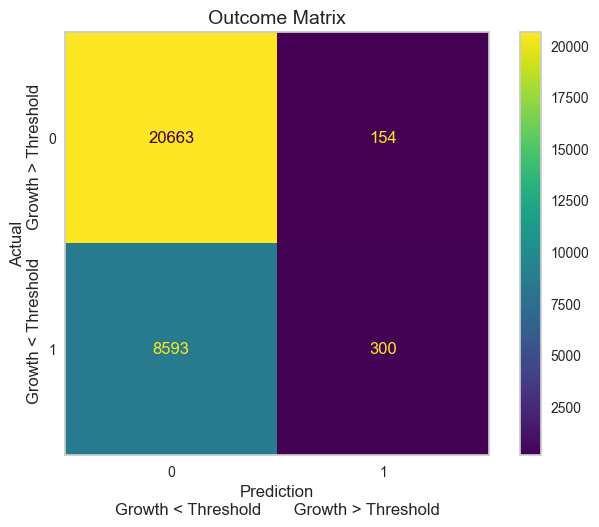

In [586]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test_2yr, predictions, labels=best_model.classes_)

# Create the ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix with the original color range and no grid
disp.plot()

# Add titles and labels with line breaks for better formatting
plt.title("Outcome Matrix", fontsize=14)
plt.xlabel("Prediction\nGrowth < Threshold       Growth > Threshold", fontsize=12)  # Line break added
plt.ylabel("Actual\nGrowth < Threshold      Growth > Threshold", fontsize=12)

# Remove grid
plt.grid(False)

# Show the plot
plt.show()